## A Simple Pair Trading Strategy

**_Please go through the "building strategies" notebook before looking at this notebook._**

Let's build a aimple pair trading strategy to show how you can trade multiple symbols in a strategy.  We will trade 2 stocks, Coca-Cola (KO) and Pepsi (PEP)

1.  We will buy KO and sell PEP when the price ratio KO / PEP is more than 1 standard deviation lower than its 5 day simple moving average.  
2.  We will buy PEP and sell KO when the price ratio KO / PEP is more than 1 standard deviation higher than its 5 day simple moving average.
3.  We will exit when the price ratio is less than +/- 0.5 standard deviations away from its simple moving average
4.  We will size the trades in 1 and 2 by allocating 10% of our capital to each trade.

First lets load some price data in fifteen minute bars.

In [1]:
import math
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats
import os
from types import SimpleNamespace

import pyqstrat as pq

pq.set_defaults() # Set some display defaults to make dataframes and plots easier to look at

try:
    ko_file = os.path.dirname(os.path.realpath(__file__)) + './support/coke_15_min_prices.csv.gz'
    pep_file = os.path.dirname(os.path.realpath(__file__)) + './support/pepsi_15_min_prices.csv.gz' # If we are running from unit tests
    
except:
    ko_file_path = '../notebooks/support/coke_15_min_prices.csv.gz'
    pep_file_path = '../notebooks/support/pepsi_15_min_prices.csv.gz'

ko_prices = pd.read_csv(ko_file_path)
pep_prices = pd.read_csv(pep_file_path)

ko_prices['timestamp'] = pd.to_datetime(ko_prices.date)
pep_prices['timestamp'] = pd.to_datetime(pep_prices.date)

timestamps = ko_prices.timestamp.values

IBM 2019-01-01 15:00 qty: 100 prc: 10.3 fee: 0.01 order: None


Lets compute the ratio of the two prices and add it to the market data.  Since the two price series have the exact same timestamps, we can simply divide the two close price series

In [2]:
ratio = ko_prices.c / pep_prices.c

Next, lets create an indicator for the zscore, and plot it.

<Figure size 432x288 with 0 Axes>

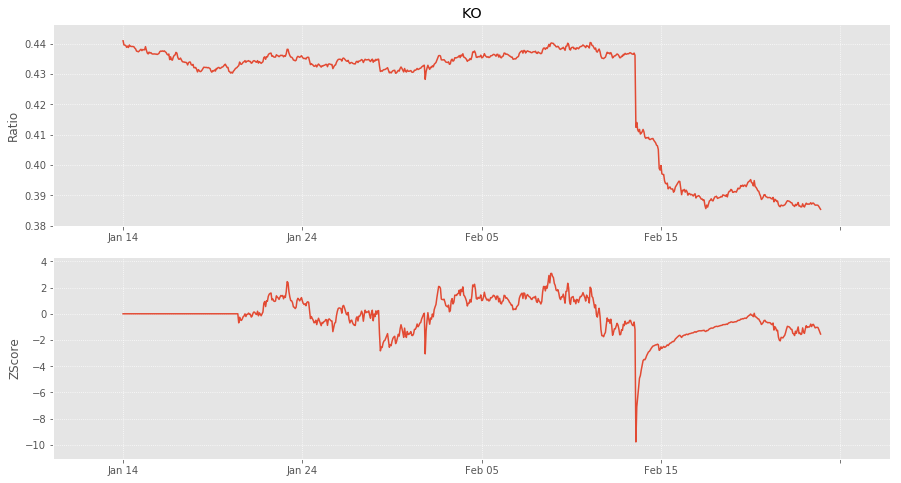

In [3]:
def zscore_indicator(symbol, timestamps, indicators, strategy_context): # simple moving average
    ratio = indicators.ratio
    r = pd.Series(ratio).rolling(window = 130)
    mean = r.mean()
    std = r.std(ddof = 0)
    zscore = (ratio - mean) / std
    zscore = np.nan_to_num(zscore)
    return zscore

ko_zscore = zscore_indicator(None, None, SimpleNamespace(ratio = ratio), None)

ratio_subplot = pq.Subplot([pq.TimeSeries('ratio', timestamps, ratio)], ylabel = 'Ratio')
zscore_subplot = pq.Subplot([pq.TimeSeries('zscore', timestamps, ko_zscore)], ylabel = 'ZScore')
plot = pq.Plot([ratio_subplot, zscore_subplot], title = 'KO')
plot.draw();



Now lets create the signal that will tell us to get in when the zscore is +/-1 and get out when its less than +/- 0.5.  We use a signal value of 2 to figure out when to go long, and -2 to figure out when to go short.  A value of 1 means get out of a long position, and -1 means get out of a short position.  We also plot the signal to check it.

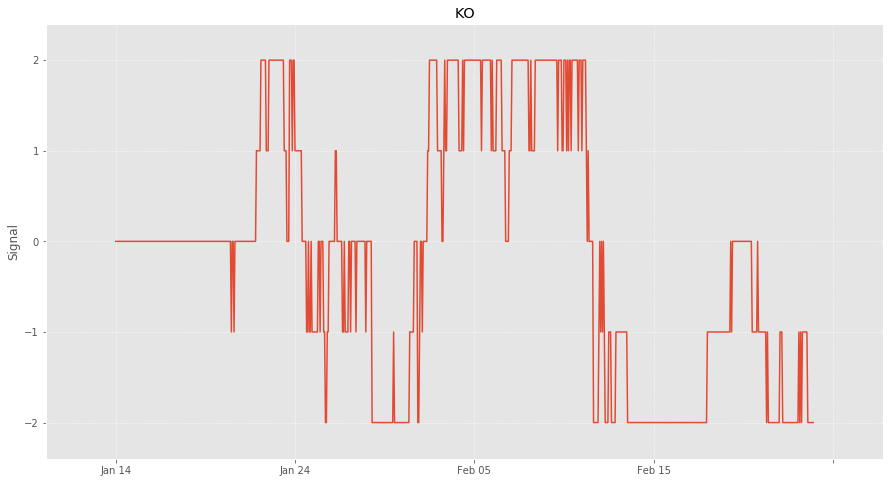

In [4]:
def pair_strategy_signal(symbol, timestamps, indicators, parent_signals, strategy_context): # We don't need any indicators since the zscore is already part of the market data
    zscore = indicators.zscore
    signal = np.where(zscore > 1, 2, 0)
    signal = np.where(zscore < -1, -2, signal)
    signal = np.where((zscore > 0.5) & (zscore < 1), 1, signal)
    signal = np.where((zscore < -0.5) & (zscore > -1), -1, signal)
    if symbol == 'PEP': signal = -1. * signal
    return signal

signal = pair_strategy_signal(None, timestamps, SimpleNamespace(zscore = ko_zscore), None, None)
signal_subplot = pq.Subplot([pq.TimeSeries('signal', timestamps, signal)], ylabel = 'Signal')
plot = pq.Plot([signal_subplot], title = 'KO', show_date_gaps = False)
plot.draw()

Finally we create the trading rule and market simulator functions

In [5]:
def pair_trading_rule(symbol, i, timestamps, indicators, signal, account, strategy_context):
    timestamp = timestamps[i]
    curr_pos = account.position(symbol, timestamp)
    signal_value = signal[i]
    risk_percent = 0.1
    
    #print(f'{timestamp} {symbol} curr_pos: {curr_pos}')
    
    orders = []
    
    # if we don't already have a position, check if we should enter a trade
    if math.isclose(curr_pos, 0):
        if signal_value == 2 or signal_value == -2:
            curr_equity = account.equity(timestamp)
            order_qty = np.round(curr_equity * risk_percent / indicators.c[i] * np.sign(signal_value))
            trigger_price = indicators.c[i]
            reason_code = pq.ReasonCode.ENTER_LONG if order_qty > 0 else pq.ReasonCode.ENTER_SHORT
            orders.append(pq.MarketOrder(symbol, timestamp, order_qty, reason_code = reason_code))
        
    else: # We have a current position, so check if we should exit
        if (curr_pos > 0 and signal_value == -1) or (curr_pos < 0 and signal_value == 1):
            order_qty = -curr_pos
            reason_code = pq.ReasonCode.EXIT_LONG if order_qty < 0 else pq.ReasonCode.EXIT_SHORT
            orders.append(pq.MarketOrder(symbol, timestamp, order_qty, reason_code = reason_code))
    #if len(orders):
    #    print(f'submitting order: {orders}')
    return orders

def market_simulator(orders, i, timestamps, indicators, signals, strategy_context):
    trades = []
    
    timestamp = timestamps[i]
    
    o, h, l, c = indicators.o[i], indicators.h[i], indicators.l[i], indicators.c[i]
    
    for order in orders:
        trade_price = np.nan
        
        if isinstance(order, pq.MarketOrder):
            trade_price = 0.5 * (o + h) if order.qty > 0 else 0.5 * (o + l)
        else:
            raise Exception(f'unexpected order type: {order}')
            
        if np.isnan(trade_price): continue
            
        trade = pq.Trade(order.symbol, timestamp, order.qty, trade_price, order = order, commission = 0, fee = 0)
        order.status = 'filled'
                           
        trades.append(trade)
    #print(f'{timestamp} got trade: {trades}')
                           
    return trades


Lets run the strategy, plot the results and look at the returns

adding indicator: c KO 0   47.35
1   47.29
2   47.31
3   47.26
4   47.27
Name: c, dtype: float64
adding indicator: c PEP 0   107.4
1   107.6
2   107.6
3   107.6
4   107.7
Name: c, dtype: float64


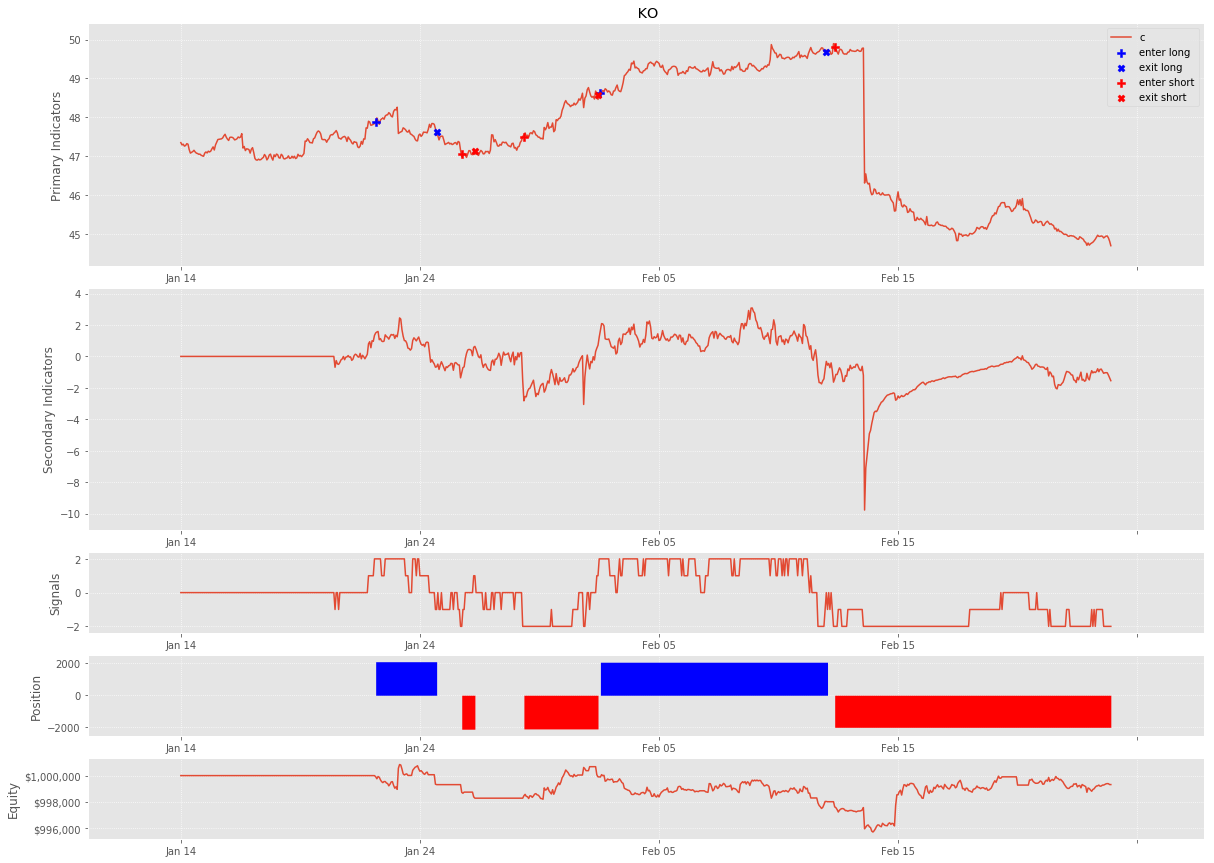

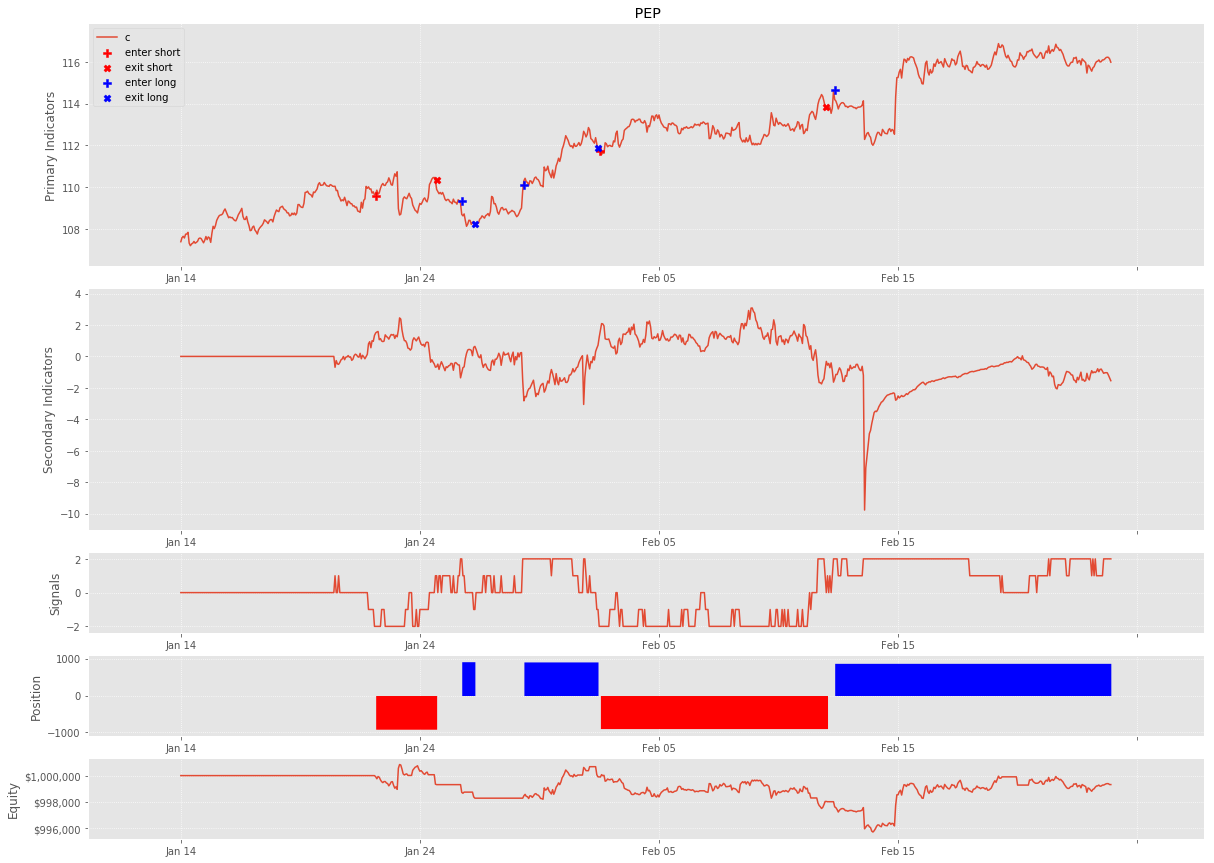

In [6]:
ko_contract = pq.Contract('KO')
pep_contract = pq.Contract('PEP')

def get_price(symbol, timestamps, i, strategy_context):
    if symbol == 'KO':
        return strategy_context.ko_price[i]
    elif symbol == 'PEP':
        return strategy_context.pep_price[i]
    raise Exception(f'Unknown symbol: {symbol}')

strategy_context = SimpleNamespace(ko_price = ko_prices.c.values, pep_price = pep_prices.c.values)

strategy = pq.Strategy([ko_contract, pep_contract], timestamps, get_price, strategy_context = strategy_context)
for tup in [('KO', ko_prices), ('PEP', pep_prices)]:
    for column in ['o', 'h', 'l', 'c']:
        if column == 'c':
            print(f'adding indicator: {column} {tup[0]} {tup[1][column].head()}')
        strategy.add_indicator(column, tup[1][column], symbols = [tup[0]])
strategy.add_indicator('ratio', ratio)
strategy.add_indicator('zscore', zscore_indicator, depends_on = ['ratio'])

strategy.add_signal('pair_strategy_signal', pair_strategy_signal, depends_on_indicators = ['zscore'])

# ask pqstrat to call our trading rule when the signal has one of the values [-2, -1, 1, 2]
strategy.add_rule('pair_trading_rule', pair_trading_rule, 
                  signal_name = 'pair_strategy_signal', sig_true_values = [-2, -1, 1, 2])

strategy.add_market_sim(market_simulator)

portfolio = pq.Portfolio()
portfolio.add_strategy('pair_strategy', strategy)
#portfolio.run(end_date = "2019-01-23 11:35:00")
portfolio.run()

strategy.plot(primary_indicators = ['c'], secondary_indicators = ['zscore'])

,gmean,amean,std,shrp,srt,calmar,mar,mdd_pct,mdd_dates,dd_3y_pct,dd_3y_timestamps,up_dwn,2019
,-0.003895,-1.524e-05,0.0006989,-0.3462,-0.645,0.8653,0.8653,-0.004439,2019-01-31/2019-02-14,-0.004439,2019-01-31/2019-02-14,11/12/0.478,-0.003895


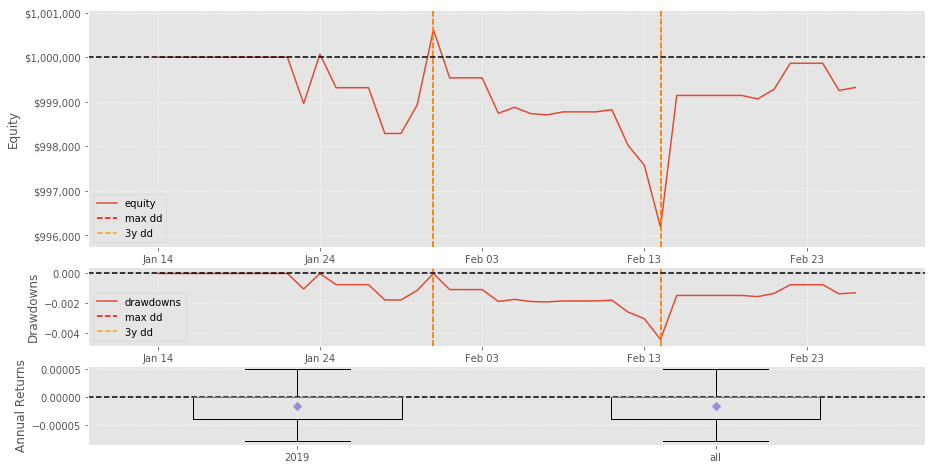

In [7]:
strategy.evaluate_returns();

In [8]:
strategy.df_trades()

,symbol,date,qty,price,fee,commission,order_date,order_qty,order_params
0,KO,2019-01-23 11:30:00,2090,47.87,0,0,2019-01-23 11:15:00,2090,{}
1,KO,2019-01-25 11:15:00,-2090,47.62,0,0,2019-01-25 11:00:00,-2090,{}
2,KO,2019-01-28 10:00:00,-2119,47.06,0,0,2019-01-28 09:45:00,-2119,{}
3,KO,2019-01-28 12:45:00,2119,47.13,0,0,2019-01-28 12:30:00,2119,{}
4,KO,2019-01-30 10:00:00,-2101,47.49,0,0,2019-01-30 09:45:00,-2101,{}
5,KO,2019-02-01 12:30:00,2101,48.58,0,0,2019-02-01 12:15:00,2101,{}
6,KO,2019-02-01 13:00:00,2058,48.63,0,0,2019-02-01 12:45:00,2058,{}
7,KO,2019-02-12 14:45:00,-2058,49.67,0,0,2019-02-12 14:30:00,-2058,{}
8,KO,2019-02-13 10:00:00,-2000,49.8,0,0,2019-02-13 09:45:00,-2000,{}
9,PEP,2019-01-23 11:30:00,-912,109.6,0,0,2019-01-23 11:15:00,-912,{}


In [9]:
strategy.df_orders()

,symbol,type,date,qty,params
0,KO,MarketOrder,2019-01-23 11:15:00,2090,{}
1,PEP,MarketOrder,2019-01-23 11:15:00,-912,{}
2,KO,MarketOrder,2019-01-25 11:00:00,-2090,{}
3,PEP,MarketOrder,2019-01-25 11:00:00,912,{}
4,KO,MarketOrder,2019-01-28 09:45:00,-2119,{}
5,PEP,MarketOrder,2019-01-28 09:45:00,915,{}
6,KO,MarketOrder,2019-01-28 12:30:00,2119,{}
7,PEP,MarketOrder,2019-01-28 12:30:00,-915,{}
8,KO,MarketOrder,2019-01-30 09:45:00,-2101,{}
9,PEP,MarketOrder,2019-01-30 09:45:00,909,{}


In [10]:
strategy.indicator_values['PEP'].ratio

array([0.44095735, 0.43957985, 0.43952062, 0.43938267, 0.43878782,
       0.43919536, 0.43874617, 0.43956761, 0.43922008, 0.43906095,
       0.43910167, 0.43906141, 0.43900848, 0.43856544, 0.43826816,
       0.43755231, 0.43747676, 0.43731982, 0.4375669 , 0.4379018 ,
       0.43815728, 0.43770324, 0.4380815 , 0.43797045, 0.4379881 ,
       0.43903121, 0.43783633, 0.43692194, 0.43662624, 0.43722263,
       0.43690037, 0.43706229, 0.43670595, 0.4365912 , 0.43661544,
       0.4366262 , 0.43656991, 0.43657641, 0.43644886, 0.4365912 ,
       0.43679167, 0.43736668, 0.43757486, 0.43748848, 0.43762677,
       0.43745387, 0.43762687, 0.43732811, 0.43709737, 0.43653165,
       0.43629432, 0.43659387, 0.43475458, 0.43568465, 0.43471646,
       0.4345704 , 0.43556725, 0.43613333, 0.4362895 , 0.43713518,
       0.43689859, 0.43554055, 0.43489531, 0.43486927, 0.43526682,
       0.43469199, 0.43414661, 0.43395616, 0.43399279, 0.43382285,
       0.43387439, 0.4336695 , 0.43298902, 0.43371824, 0.43396